# Import Library 

In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import tensorflow as tf

# Loading Data From File

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/APS360 Project/chest_xray.zip' -d '/root/datasets'
#!unzip '/content/drive/MyDrive/Year 2/aps360/APS360 Project/chest_xray.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/chest_xray/train/NORMAL/NORMAL2-IM-0276-0001 copy.jpeg  
  inflating: /root/datasets/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0276-0001 copy.jpeg  
  inflating: /root/datasets/chest_xray/train/NORMAL/IM-0152-0001 copy 2.jpeg  
  inflating: /root/datasets/__MACOSX/chest_xray/train/NORMAL/._IM-0152-0001 copy 2.jpeg  
  inflating: /root/datasets/chest_xray/train/NORMAL/IM-0734-0001 copy 7.jpeg  
  inflating: /root/datasets/__MACOSX/chest_xray/train/NORMAL/._IM-0734-0001 copy 7.jpeg  
  inflating: /root/datasets/chest_xray/train/NORMAL/IM-0757-0001 copy 2.jpeg  
  inflating: /root/datasets/__MACOSX/chest_xray/train/NORMAL/._IM-0757-0001 copy 2.jpeg  
  inflating: /root/datasets/chest_xray/train/NORMAL/IM-0428-0001.jpeg  
  inflating: /root/datasets/__MACOSX/chest_xray/train/NORMAL/._IM-0428-0001.jpeg  
  inflating: /root/datasets/chest_xray/train/NORMAL/NORMAL2-IM-0300-0001 copy 2.jpeg  
  inflating: /root/

# Define training and test data directories

In [ ]:
data_dir = '/root/datasets/chest_xray'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir,'test/')
# classes are folders in each directory with these names
classes = ['NORMAL', 'PNEUMONIA']
train_normal = train_dir+'NORMAL/'
train_pneumonia = train_dir+'PNEUMONIA/'

# Data Loading Test

Normal picture is :  /root/datasets/chest_xray/train/NORMAL/IM-0439-0001 copy.jpeg
Normal picture is :  /root/datasets/chest_xray/train/PNEUMONIA/person1472_bacteria_3833.jpeg


Text(0.5, 1.0, 'Pneumonia')

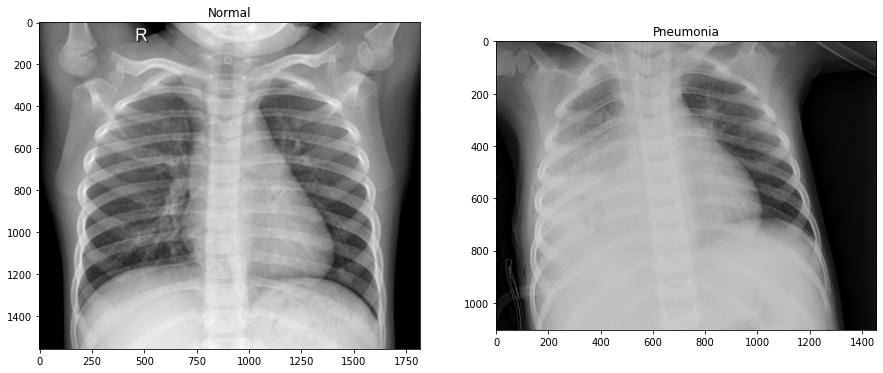

In [ ]:
rand1 = np.random.randint(0,len(os.listdir(train_normal)))
img1 = train_normal+os.listdir(train_normal)[rand1]
print('Normal picture is : ',img1)

rand2 = np.random.randint(0,len(os.listdir(train_pneumonia)))
img2 = train_pneumonia+os.listdir(train_pneumonia)[rand2]
print('Normal picture is : ',img2)

fig = plt.figure(1, figsize = (15,7))

f1 = fig.add_subplot(1,2,1)
plt.imshow(Image.open(img1),cmap = 'gray')
f1.set_title('Normal')

f2 = fig.add_subplot(1,2,2)
plt.imshow(Image.open(img2),cmap = 'gray')
f2.set_title('Pneumonia')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


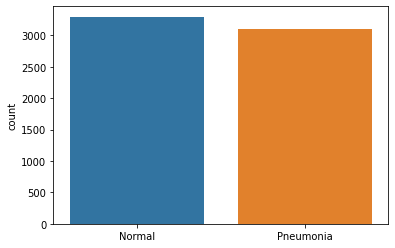

In [ ]:
li = []
for i in range(0,len(os.listdir(train_normal))):
    li.append('Normal')
for i in range(0,len(os.listdir(train_pneumonia))):
    li.append('Pneumonia')
sns.countplot(li)

# Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# for training set
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (256,256),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 6397 images belonging to 2 classes.


In [ ]:
# for test set
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (256,256),
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 1172 images belonging to 2 classes.


In [ ]:
# for validation set
validation_set = test_datagen.flow_from_directory(val_dir,
                                            target_size = (256,256),
                                            batch_size = 16,
                                            class_mode = 'binary')


Found 1172 images belonging to 2 classes.


In [ ]:
# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# Model building and Sanity Check

In [ ]:
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# define dataloader parameters
batch_size  = 256
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
class CNNClassifier(nn.Module):
      def __init__(self):
          super(CNNClassifier, self).__init__()
          #self.fc1 = nn.Linear(256 * 6 * 6, 10)
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
          self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
          self.fc1 = nn.Linear(10*53*53, 32)
          self.fc2 = nn.Linear(32, 2)

      def forward(self, x):
          #x = x.view(-1, 256 * 6 * 6) #flatten feature data
          #x = F.relu(self.fc1(x))
          x = self.pool(F.relu(self.conv1(x))) # (224 + 2*0 - 1*(5-1) -1)/1 + 1 = 220 x 220 --> (220 + 2*0 - 1*(2-1) - 1)/2 + 1 = 110 x 110 halves the image
          x = self.pool(F.relu(self.conv2(x))) # 106 x 106 --> 53 x 53 ten of these 53 x 53 images
          x = x.view(-1, 10*53*53) # flattening and reshaping to a 1d vector 53*53*10
          x = F.relu(self.fc1(x)) #relu activation function
          x = self.fc2(x)
          return x

In [ ]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        #output = model(ALNC(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            #out = model(ALNC(imgs)) 
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        print("epoch:", epoch, "training accuracy:", train_acc[epoch], "validation accuracy:", val_acc[epoch]) # Checkpoint

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
epoch: 0 training accuracy: 0.6492105674534938 validation accuracy: 0.6646757679180887
epoch: 1 training accuracy: 0.7642644989838987 validation accuracy: 0.78839590443686
epoch: 2 training accuracy: 0.5243082695013287 validation accuracy: 0.5443686006825939
epoch: 3 training accuracy: 0.7672346412380804 validation accuracy: 0.7764505119453925
epoch: 4 training accuracy: 0.7995935594810067 validation accuracy: 0.7909556313993175
epoch: 5 training accuracy: 0.806784430201657 validation accuracy: 0.8199658703071673
epoch: 6 training accuracy: 0.8106925121150539 validation accuracy: 0.8267918088737202
epoch: 7 training accuracy: 0.7975613568860404 validation accuracy: 0.8165529010238908
epoch: 8 training accuracy: 0.8083476629670158 validation accuracy: 0.8242320819112628
epoch: 9 training accuracy: 0.794122244802251 validation accuracy: 0.802901023890785
epoch: 10 training accuracy: 0.8228857276848522 validation accuracy: 0.8088737201365188
epoch: 

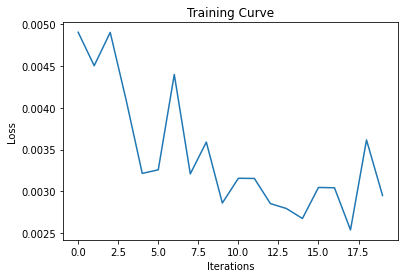

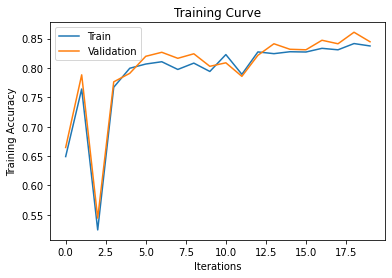

Final Training Accuracy: 0.8375801156792246
Final Validation Accuracy: 0.8447098976109215


In [ ]:
#baseline model
use_cuda = True
model = CNNClassifier()
#ALNC = alexNet.features
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(model, train_data, val_data, batch_size=128, num_epochs=20)

In [ ]:
model = CNNClassifier()
kernels = model.conv1.weight.detach()
kernels = kernels.cpu()

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

#display all five kernels of dimension 5 x 5
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][2])
    
#load image from the internet
url = 'https://prod-images-static.radiopaedia.org/images/157210/332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

#ensure image is np.array
img = np.array(img)

#plot original image
plt.title("Image")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#select kernel
k = kernels[0][2]

#perform 2d convolution
img_k = sg.convolve(img_gray, k, mode='same')

print('Image Max Value:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

#normalize images
img_k[img_k > 255] = 255
img_k[img_k < 0] = 0

print('Image Max Value:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

#return to image format
img_k = img_k.astype(np.uint8)

#plot results of convolution
plt.title("Feature Map for 1st Kernel")
plt.imshow(img_k, cmap='gray')
plt.show()

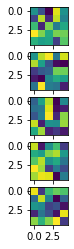

In [ ]:
#display all five kernels of dimension 5 x 5
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][2])

In [ ]:
for i in range(5):
  for j in range(3):

    k = kernels[i][j]
    url = 'https://prod-images-static.radiopaedia.org/images/157210/332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg'
    resp = requests.get(url, stream=True).raw
    img = Image.open(resp)

    #ensure image is np.array
    img = np.array(img)
    img = img.astype(np.int16)
    img_gray = rgb2gray(img)
    img_k = sg.convolve(img_gray, k, mode='same')
    img_k[img_k > 255] = 255
    img_k[img_k < 0] = 0
    img_k = img_k.astype(np.uint8)
    plt.imshow(img_k, cmap='gray')
    print(i, j)
    plt.show()

CUDA is available!  Training on GPU ...
epoch: 0 training accuracy: 0.6979834297326872 validation accuracy: 0.6962457337883959
epoch: 1 training accuracy: 0.7498827575425981 validation accuracy: 0.7755972696245734
epoch: 2 training accuracy: 0.720962951383461 validation accuracy: 0.7414675767918089
epoch: 3 training accuracy: 0.8131936845396279 validation accuracy: 0.8216723549488054
epoch: 4 training accuracy: 0.8241363138971393 validation accuracy: 0.8233788395904437
epoch: 5 training accuracy: 0.8197592621541347 validation accuracy: 0.8284982935153583
epoch: 6 training accuracy: 0.8261685164921057 validation accuracy: 0.8361774744027304
epoch: 7 training accuracy: 0.8300765984055026 validation accuracy: 0.8549488054607508
epoch: 8 training accuracy: 0.8045959043301547 validation accuracy: 0.818259385665529
epoch: 9 training accuracy: 0.8360168829138659 validation accuracy: 0.841296928327645
epoch: 10 training accuracy: 0.8349226199781148 validation accuracy: 0.8361774744027304
epoch

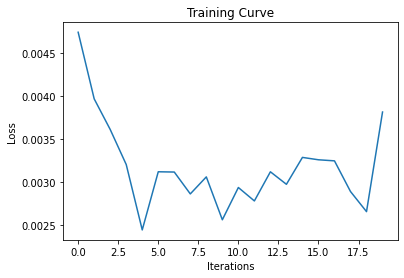

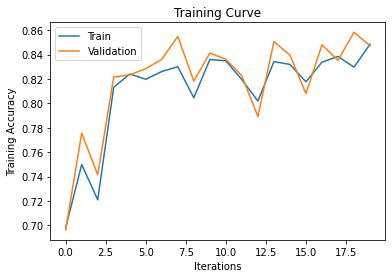

Final Training Accuracy: 0.848522745036736
Final Validation Accuracy: 0.8472696245733788


In [ ]:
#testing data
use_cuda = True
model = CNNClassifier()
ALNC = alexNet.features
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(model, train_data, test_data, batch_size=128, num_epochs=20)

''

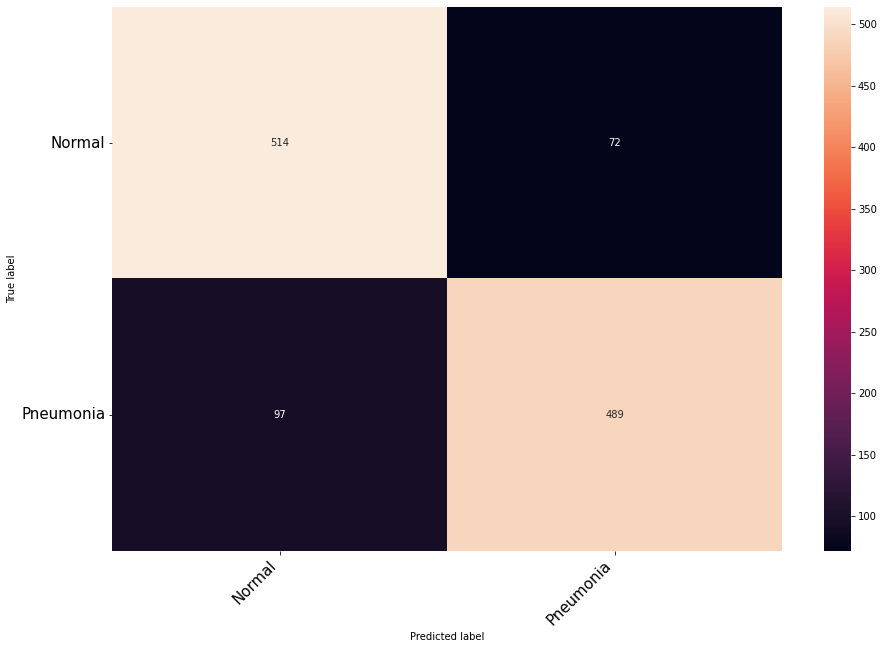

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = ("Normal", "Pneumonia")
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

In [ ]:
torch.manual_seed(1) # set the random seed

# Convolution Neural Network Architecture
class CNNClassifier(nn.Module):
      def __init__(self):
          super(CNNClassifier, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
          self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
          self.fc1 = nn.Linear(10*53*53, 32)
          self.fc2 = nn.Linear(32, 9)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x))) # (224 + 2*0 - 1*(5-1) -1)/1 + 1 = 220 x 220 --> (220 + 2*0 - 1*(2-1) - 1)/2 + 1 = 110 x 110 halves the image
          x = self.pool(F.relu(self.conv2(x))) # 106 x 106 --> 53 x 53 ten of these 53 x 53 images
          x = x.view(-1, 10*53*53) # flattening and reshaping to a 1d vector 53*53*10
          x = F.relu(self.fc1(x)) #relu activation function
          x = self.fc2(x)
          return x

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        #output = model(ALNC(imgs))
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data_loader, batch_size=20, num_epochs=1, learning_rate=0.01):
    # train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(data_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
          
            out = model(imgs)
            #out = model(ALNC(imgs))            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

In [ ]:
use_cuda = True

model = CNNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

CUDA is available!  Training on GPU ...


In [ ]:
sample = list(range(0, 64))
train_sampler = SubsetRandomSampler(sample)
sample_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                               num_workers=1, 
                                               sampler=train_sampler)


NameError: ignored

Iteration:  1 Progress:   0.27  % Time Elapsed:  29.03 s 
Epoch 0 Finished.  Time per Epoch:  29.09 s 
Iteration:  2 Progress:   6.93  % Time Elapsed:  55.36 s 
Epoch 1 Finished.  Time per Epoch:  27.71 s 
Iteration:  3 Progress:  13.60  % Time Elapsed:  82.76 s 
Epoch 2 Finished.  Time per Epoch:  27.61 s 
Iteration:  4 Progress:  20.27  % Time Elapsed:  109.52 s 
Epoch 3 Finished.  Time per Epoch:  27.39 s 
Iteration:  5 Progress:  26.93  % Time Elapsed:  136.49 s 
Epoch 4 Finished.  Time per Epoch:  27.31 s 
Iteration:  6 Progress:  33.60  % Time Elapsed:  163.53 s 
Epoch 5 Finished.  Time per Epoch:  27.27 s 
Iteration:  7 Progress:  40.27  % Time Elapsed:  189.14 s 
Epoch 6 Finished.  Time per Epoch:  27.03 s 
Iteration:  8 Progress:  46.93  % Time Elapsed:  214.99 s 
Epoch 7 Finished.  Time per Epoch:  26.88 s 
Iteration:  9 Progress:  53.60  % Time Elapsed:  241.02 s 
Epoch 8 Finished.  Time per Epoch:  26.79 s 
Iteration:  10 Progress:  60.27  % Time Elapsed:  267.31 s 
Epoch 9

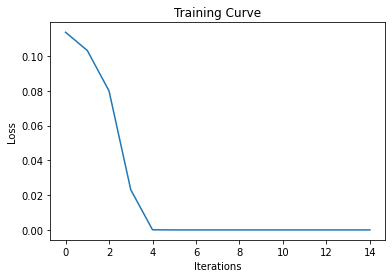

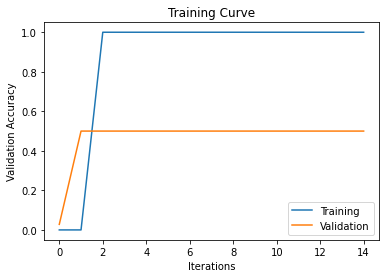

Final Training Accuracy: 0.5152415194622479
Final Validation Accuracy: 0.5
Total time:   400.27 s  Time per Epoch:  26.68 s 


RuntimeError: ignored

In [ ]:
train(model, sample_loader, num_epochs=15)

#obtain accuracy on 64 samples
correct = 0
total = 0
for imgs, labels in iter(sample_loader):
    if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()  
    output = model(ALNC(imgs))    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
print('Accuracy on batch of 64: ', correct / total)